# Import Packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from datetime import datetime
from scipy.stats import probplot

import warnings
warnings.filterwarnings('ignore')

SEED = 42


In [2]:
#for plotly ONLY
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
warnings.filterwarnings('ignore')
import plotly.figure_factory as ff

# Input Datasource

In [3]:
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

In [4]:
print(df_train.shape)
print("*"*30)
print(df_test.shape)

(1460, 81)
******************************
(1459, 80)


#### Data Dimensions:
Train = (1460, 81)
******************************
Test = (1459, 80)

# Main settings

In [5]:
#Show all columns, rows, width
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

#### Controlling Parameters

In [6]:
# target variable  for correlation 
target = 'SalePrice_Log'

# select variables with correlation above this threshold value
min_val_corr = 0.30

# setting the number of cross validations used in the Model part 
nr_cv = 5

# switch for using log values for SalePrice and features     
use_logvals = 1    
      
# switch for dropping columns that are similar to others already used and show a high correlation to these     
drop_similar = 1

#### Controlling functions

In [7]:
def print_cols_large_corr(df, nr_c, targ) :
    corr = df.corr()
    corr_abs = corr.abs()
    print (corr_abs.nlargest(nr_c, targ)[targ])
    
    

In [8]:
def plot_corr_matrix(df, nr_c, targ) :
    
    corr = df.corr()
    corr_abs = corr.abs()
    cols = corr_abs.nlargest(nr_c, targ)[targ].index
    cm = np.corrcoef(df[cols].values.T)

    plt.figure(figsize=(nr_c/1.5, nr_c/1.5))
    sns.set(font_scale=1.25)
    sns.heatmap(cm, linewidths=1.5, annot=True, square=True, 
                fmt='.2f', annot_kws={'size': 10}, 
                yticklabels=cols.values, xticklabels=cols.values
               )
    plt.show()

# 1] :  EDA / Exploratory Data Analysis
*******************************************************

## 1.1 Features & relations to Target variable
- Which features are numerical, which are categorical?
- How many values are missing?



In [9]:
df_train.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape LandContour Utilities LotConfig LandSlope Neighborhood Condition1 Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional  Fireplaces FireplaceQu GarageType  GarageYrBlt GarageFinish  GarageCars  GarageArea GarageQual GarageCond PavedDrive  WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  PoolArea PoolQC Fence MiscFeature  MiscVal  MoSold  YrSold SaleType SaleCondition  SalePrice
0   1          60       RL         65.0     8450   Pave   NaN      Reg         Lvl    AllPub    Inside       Gtl      CollgCr       Norm       Norm     1Fam     2Story            7            5       2003          2003     Gable  CompShg     VinylSd     VinylSd    BrkFace       196.0        Gd        TA      PConc       Gd       TA           No          GLQ         706          Unf           0        150          856    GasA        Ex          Y      SBrkr       856       854             0       1710             1             0         2         1             3             1          Gd             8        Typ           0         NaN     Attchd       2003.0          RFn           2         548         TA         TA          Y           0           61              0          0            0         0    NaN   NaN         NaN        0       2    2008       WD        Normal     208500
1   2          20       RL         80.0     9600   Pave   NaN      Reg         Lvl    AllPub       FR2       Gtl      Veenker      Feedr       Norm     1Fam     1Story            6            8       1976          1976     Gable  CompShg     MetalSd     MetalSd       None         0.0        TA        TA     CBlock       Gd       TA           Gd          ALQ         978          Unf           0        284         1262    GasA        Ex          Y      SBrkr      1262         0             0       1262             0             1         2         0             3             1          TA             6        Typ           1          TA     Attchd       1976.0          RFn           2         460         TA         TA          Y         298            0              0          0            0         0    NaN   NaN         NaN        0       5    2007       WD        Normal     181500
2   3          60       RL         68.0    11250   Pave   NaN      IR1         Lvl    AllPub    Inside       Gtl      CollgCr       Norm       Norm     1Fam     2Story            7            5       2001          2002     Gable  CompShg     VinylSd     VinylSd    BrkFace       162.0        Gd        TA      PConc       Gd       TA           Mn          GLQ         486          Unf           0        434          920    GasA        Ex          Y      SBrkr       920       866             0       1786             1             0         2         1             3             1          Gd             6        Typ           1          TA     Attchd       2001.0          RFn           2         608         TA         TA          Y           0           42              0          0            0         0    NaN   NaN         NaN        0       9    2008       WD        Normal     223500
3   4          70       RL         60.0     9550   Pave   NaN      IR1         Lvl    AllPub    Corner       Gtl      Crawfor       Norm       Norm     1Fam     2Story            7            5       1915          1970     Gable  CompShg     Wd Sdng     Wd Shng       None         0.0        TA        TA     BrkTil       TA       Gd           No          ALQ         216          Unf           0        540          756   

In [10]:
df_train.describe()

Id   MSSubClass  LotFrontage        LotArea  OverallQual  OverallCond    YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1   BsmtFinSF2    BsmtUnfSF  TotalBsmtSF     1stFlrSF     2ndFlrSF  LowQualFinSF    GrLivArea  BsmtFullBath  BsmtHalfBath     FullBath     HalfBath  BedroomAbvGr  KitchenAbvGr  TotRmsAbvGrd   Fireplaces  GarageYrBlt   GarageCars   GarageArea   WoodDeckSF  OpenPorchSF  EnclosedPorch    3SsnPorch  ScreenPorch     PoolArea       MiscVal       MoSold       YrSold      SalePrice
count  1460.000000  1460.000000  1201.000000    1460.000000  1460.000000  1460.000000  1460.000000   1460.000000  1452.000000  1460.000000  1460.000000  1460.000000  1460.000000  1460.000000  1460.000000   1460.000000  1460.000000   1460.000000   1460.000000  1460.000000  1460.000000   1460.000000   1460.000000   1460.000000  1460.000000  1379.000000  1460.000000  1460.000000  1460.000000  1460.000000    1460.000000  1460.000000  1460.000000  1460.000000   1460.000000  1460.000000  1460.000000    1460.000000
mean    730.500000    56.897260    70.049958   10516.828082     6.099315     5.575342  1971.267808   1984.865753   103.685262   443.639726    46.549315   567.240411  1057.429452  1162.626712   346.992466      5.844521  1515.463699      0.425342      0.057534     1.565068     0.382877      2.866438      1.046575      6.517808     0.613014  1978.506164     1.767123   472.980137    94.244521    46.660274      21.954110     3.409589    15.060959     2.758904     43.489041     6.321918  2007.815753  180921.195890
std     421.610009    42.300571    24.284752    9981.264932     1.382997     1.112799    30.202904     20.645407   181.066207   456.098091   161.319273   441.866955   438.705324   386.587738   436.528436     48.623081   525.480383      0.518911      0.238753     0.550916     0.502885      0.815778      0.220338      1.625393     0.644666    24.689725     0.747315   213.804841   125.338794    66.256028      61.119149    29.317331    55.757415    40.177307    496.123024     2.703626     1.328095   79442.502883
min       1.000000    20.000000    21.000000    1300.000000     1.000000     1.000000  1872.000000   1950.000000     0.000000     0.000000     0.000000     0.000000     0.000000   334.000000     0.000000      0.000000   334.000000      0.000000      0.000000     0.000000     0.000000      0.000000      0.000000      2.000000     0.000000  1900.000000     0.000000     0.000000     0.000000     0.000000       0.000000     0.000000     0.000000     0.000000      0.000000     1.000000  2006.000000   34900.000000
25%     365.750000    20.000000    59.000000    7553.500000     5.000000     5.000000  1954.000000   1967.000000     0.000000     0.000000     0.000000   223.000000   795.750000   882.000000     0.000000      0.000000  1129.500000      0.000000      0.000000     1.000000     0.000000      2.000000      1.000000      5.000000     0.000000  1961.000000     1.000000   334.500000     0.000000     0.000000       0.000000     0.000000     0.000000     0.000000      0.000000     5.000000  2007.000000  129975.000000
50%     730.500000    50.000000    69.000000    9478.500000     6.000000     5.000000  1973.000000   1994.000000     0.000000   383.500000     0.000000   477.500000   991.500000  1087.000000     0.000000      0.000000  1464.000000      0.000000      0.000000     2.000000     0.000000      3.000000      1.000000      6.000000     1.000000  1980.000000     2.000000   480.000000     0.000000    25.000000       0.000000     0.000000     0.000000     0.000000      0.000000     6.000000  2008.000000  163000.000000
75%    1095.250000    70.000000    80.000000   11601.500000     7.000000     6.000000  2000.000000   2004.000000   166.000000   712.250000     0.000000   808.000000  1298.250000  1391.250000   728.000000      0.000000  1776.750000      1.000000      0.000000     2.000000     1.000000      3.000000      1.000000      7.000000     1.000000  2002.000000     2.000000   576.000000   168.000000    68.000000       0.00000

### TARGET VARIABLE

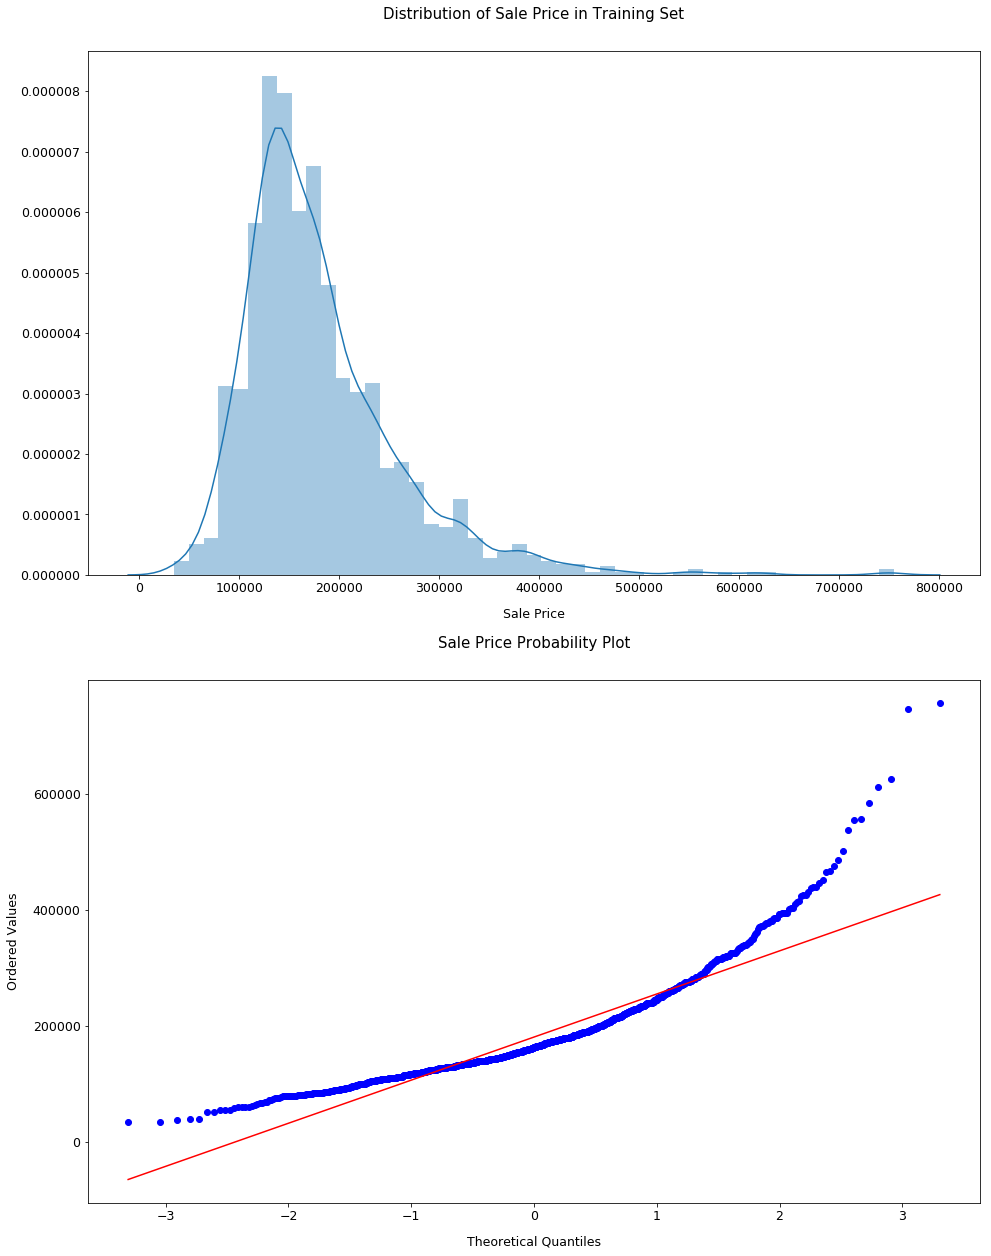

In [12]:
fig, axs = plt.subplots(nrows=2, figsize=(16, 16))
plt.subplots_adjust(left=None, bottom=5, right=None, top=6, wspace=None, hspace=None)

sns.distplot(df_train['SalePrice'], hist=True, ax=axs[0])
probplot(df_train['SalePrice'], plot=axs[1])

axs[0].set_xlabel('Sale Price', size=12.5, labelpad=12.5)
axs[1].set_xlabel('Theoretical Quantiles', size=12.5, labelpad=12.5)
axs[1].set_ylabel('Ordered Values', size=12.5, labelpad=12.5)

for i in range(2):
    axs[i].tick_params(axis='x', labelsize=12.5)
    axs[i].tick_params(axis='y', labelsize=12.5)

axs[0].set_title('Distribution of Sale Price in Training Set', size=15, y=1.05)
axs[1].set_title('Sale Price Probability Plot', size=15, y=1.05)

plt.show()

### OTHER VARIABLES : CATEGORICAL + NUMERICAL

In [35]:
numerical_feats = df_train.dtypes[df_train.dtypes != "object"].index
print("Number of Numerical features: ", len(numerical_feats))

categorical_feats = df_train.dtypes[df_train.dtypes == "object"].index
print("Number of Categorical features: ", len(categorical_feats))



Number of Numerical features:  38
Number of Categorical features:  43


### Number of Numerical features:  38


### Number of Categorical features:  43

In [15]:
print('Numerical Features')
print(df_train[numerical_feats].columns)
print("*"*100)
print("*"*100)
print('Categorical Features')
print(df_train[categorical_feats].columns)
print("*"*100)



Numerical Features
Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice'], dtype='object')
****************************************************************************************************
****************************************************************************************************
Categorical Features
Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', '

## Features with missing vales

In [16]:
#missing data
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)


Total   Percent
PoolQC         1453  0.995205
MiscFeature    1406  0.963014
Alley          1369  0.937671
Fence          1179  0.807534
FireplaceQu     690  0.472603
LotFrontage     259  0.177397
GarageCond       81  0.055479
GarageType       81  0.055479
GarageYrBlt      81  0.055479
GarageFinish     81  0.055479
GarageQual       81  0.055479
BsmtExposure     38  0.026027
BsmtFinType2     38  0.026027
BsmtFinType1     37  0.025342
BsmtCond         37  0.025342
BsmtQual         37  0.025342
MasVnrArea        8  0.005479
MasVnrType        8  0.005479
Electrical        1  0.000685
Utilities         0  0.000000

In [17]:
nullIndex = df_train.isnull().any().index[df_train.isnull().any()]
nullTrain = df_train.loc[:, nullIndex].copy()
for col in nullTrain.columns:
    nullPos = nullTrain[col].isnull()
    nullTrain.loc[~nullPos, col] = 'Exist'
    nullTrain.loc[nullPos, col] = 'Null'

nullTrain = nullTrain.apply(lambda x: pd.Series.value_counts(x)).T
nullTrain = nullTrain.sort_values('Exist')

trace1 = go.Bar(
    x = nullTrain['Exist'],
    y = nullTrain.index,
    name = 'Exist',
    orientation = 'h',
    marker = dict(
        color = 'rgba(10, 78, 139, 0.6)',
        line = dict(
            color = 'rgba(10, 78, 139, 1.0)',
            width = 3)
    )
)
trace2 = go.Bar(
    x = nullTrain['Null'],
    y = nullTrain.index,
    name = 'Null',
    orientation = 'h',
    marker = dict(
        color = 'rgba(58, 71, 80, 0.6)',
        line = dict(
            color = 'rgba(58, 71, 80, 1.0)',
            width = 3)
    )
)


data = [trace1, trace2]
layout1 = go.Layout(
    width = 800,
    height = 400,
    barmode = 'stack',
    title = 'Null Value BarPlot'
    )
fig = go.Figure(data = data, layout = layout1)


#plot
py.iplot(fig)
indexList = df_train.index
df_train = df_train.loc[df_train[['Electrical', 'MasVnrArea', 'MasVnrType']].isnull().sum(axis=1) == 0, :]

val = round(max(df_train.corr().loc['LotFrontage', :].drop('LotFrontage')),2)

from sklearn import linear_model
dfImpute = df_train.loc[:, ['1stFlrSF', 'LotArea', 'LotFrontage']].copy()
testIx = dfImpute.loc[:,'LotFrontage'].isnull()
dfTrain = dfImpute.loc[~testIx, :]
dfTest = dfImpute.loc[testIx, :]
lr = linear_model.LinearRegression()
lr.fit(dfTrain.loc[:, ['1stFlrSF', 'LotArea', 'LotArea']], dfTrain.loc[:, 'LotFrontage'])
lrImpute = lr.predict(dfTest.loc[:, ['1stFlrSF', 'LotArea', 'LotArea']])

# Filling Missing Values [1] : NONE
Value with NULL and not necessarily missing value BUT no value e.g. PoolQC null means "no pool" or NONE

In [19]:
cols_fillna = ['PoolQC','MiscFeature','Alley','Fence','MasVnrType','FireplaceQu',
               'GarageQual','GarageCond','GarageFinish','GarageType', 'Electrical',
               'KitchenQual', 'SaleType', 'Functional', 'Exterior2nd', 'Exterior1st',
               'BsmtExposure','BsmtCond','BsmtQual','BsmtFinType1','BsmtFinType2',
               'MSZoning', 'Utilities']

# 23 variables with na and could be translated to none

In [20]:
###### replace 'NaN' with 'None' in these columns (23 variables)
for col in cols_fillna:
    df_train[col].fillna('None',inplace=True)
    df_test[col].fillna('None',inplace=True)

In [21]:
df_test.head()
df_train.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape LandContour Utilities LotConfig LandSlope Neighborhood Condition1 Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional  Fireplaces FireplaceQu GarageType  GarageYrBlt GarageFinish  GarageCars  GarageArea GarageQual GarageCond PavedDrive  WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  PoolArea PoolQC Fence MiscFeature  MiscVal  MoSold  YrSold SaleType SaleCondition  SalePrice
0   1          60       RL         65.0     8450   Pave  None      Reg         Lvl    AllPub    Inside       Gtl      CollgCr       Norm       Norm     1Fam     2Story            7            5       2003          2003     Gable  CompShg     VinylSd     VinylSd    BrkFace       196.0        Gd        TA      PConc       Gd       TA           No          GLQ         706          Unf           0        150          856    GasA        Ex          Y      SBrkr       856       854             0       1710             1             0         2         1             3             1          Gd             8        Typ           0        None     Attchd       2003.0          RFn           2         548         TA         TA          Y           0           61              0          0            0         0   None  None        None        0       2    2008       WD        Normal     208500
1   2          20       RL         80.0     9600   Pave  None      Reg         Lvl    AllPub       FR2       Gtl      Veenker      Feedr       Norm     1Fam     1Story            6            8       1976          1976     Gable  CompShg     MetalSd     MetalSd       None         0.0        TA        TA     CBlock       Gd       TA           Gd          ALQ         978          Unf           0        284         1262    GasA        Ex          Y      SBrkr      1262         0             0       1262             0             1         2         0             3             1          TA             6        Typ           1          TA     Attchd       1976.0          RFn           2         460         TA         TA          Y         298            0              0          0            0         0   None  None        None        0       5    2007       WD        Normal     181500
2   3          60       RL         68.0    11250   Pave  None      IR1         Lvl    AllPub    Inside       Gtl      CollgCr       Norm       Norm     1Fam     2Story            7            5       2001          2002     Gable  CompShg     VinylSd     VinylSd    BrkFace       162.0        Gd        TA      PConc       Gd       TA           Mn          GLQ         486          Unf           0        434          920    GasA        Ex          Y      SBrkr       920       866             0       1786             1             0         2         1             3             1          Gd             6        Typ           1          TA     Attchd       2001.0          RFn           2         608         TA         TA          Y           0           42              0          0            0         0   None  None        None        0       9    2008       WD        Normal     223500
3   4          70       RL         60.0     9550   Pave  None      IR1         Lvl    AllPub    Corner       Gtl      Crawfor       Norm       Norm     1Fam     2Story            7            5       1915          1970     Gable  CompShg     Wd Sdng     Wd Shng       None         0.0        TA        TA     BrkTil       TA       Gd           No          ALQ         216          Unf           0        540          756   

### CHECK missing data again after imputing NAs with 'none'

In [22]:
# CHECK missing data again - results include NUMERIC variable mostly
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(5)

Total   Percent
LotFrontage    257  0.177119
GarageYrBlt     81  0.055824
SalePrice        0  0.000000
ExterCond        0  0.000000
RoofStyle        0  0.000000

# Filling Missing Values [2] : MEAN
Value with NULL in numerical features


In [23]:
# fillna with mean for the remaining columns: LotFrontage, GarageYrBlt, MasVnrArea
df_train.fillna(df_train.mean(), inplace=True)
df_test.fillna(df_test.mean(), inplace=True)

In [24]:
#vaidate missing data again
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(5)

Total  Percent
SalePrice        0      0.0
Heating          0      0.0
RoofStyle        0      0.0
RoofMatl         0      0.0
Exterior1st      0      0.0

Missing value imputation complete 

#### Check for missing values in Train and Test Data below:


In [25]:
print(df_train.isnull().sum().sum())
print(df_test.isnull().sum().sum())


0
0


## Check for skewness and Kurtosis

In [26]:
#for numerical variables
for col in numerical_feats:
    print('{:15}'.format(col), 
          'Skewness: {:05.2f}'.format(df_train[col].skew()) , 
          '   ' ,
          'Kurtosis: {:06.2f}'.format(df_train[col].kurt())  
         )

Id              Skewness: 00.00     Kurtosis: -01.20
MSSubClass      Skewness: 01.41     Kurtosis: 001.58
LotFrontage     Skewness: 02.40     Kurtosis: 021.93
LotArea         Skewness: 12.24     Kurtosis: 203.58
OverallQual     Skewness: 00.21     Kurtosis: 000.09
OverallCond     Skewness: 00.69     Kurtosis: 001.09
YearBuilt       Skewness: -0.61     Kurtosis: -00.44
YearRemodAdd    Skewness: -0.50     Kurtosis: -01.28
MasVnrArea      Skewness: 02.67     Kurtosis: 010.08
BsmtFinSF1      Skewness: 01.70     Kurtosis: 011.29
BsmtFinSF2      Skewness: 04.24     Kurtosis: 019.96
BsmtUnfSF       Skewness: 00.92     Kurtosis: 000.48
TotalBsmtSF     Skewness: 01.54     Kurtosis: 013.44
1stFlrSF        Skewness: 01.37     Kurtosis: 005.83
2ndFlrSF        Skewness: 00.82     Kurtosis: -00.55
LowQualFinSF    Skewness: 08.98     Kurtosis: 082.69
GrLivArea       Skewness: 01.37     Kurtosis: 004.93
BsmtFullBath    Skewness: 00.60     Kurtosis: -00.82
BsmtHalfBath    Skewness: 04.09     Kurtosis: 

## APPLY tranformations for skewed columns

Skewness: 0.121938
Kurtosis: 0.802538


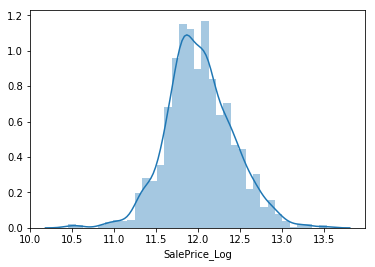

In [27]:
# ONLY TARGET VARIABLE

df_train['SalePrice_Log'] = np.log(df_train['SalePrice'])

sns.distplot(df_train['SalePrice_Log']);
# skewness and kurtosis
print("Skewness: %f" % df_train['SalePrice_Log'].skew())
print("Kurtosis: %f" % df_train['SalePrice_Log'].kurt())
# dropping old column
df_train.drop('SalePrice', axis= 1, inplace=True)

Skewness: 1.373512
Kurtosis: 4.927436


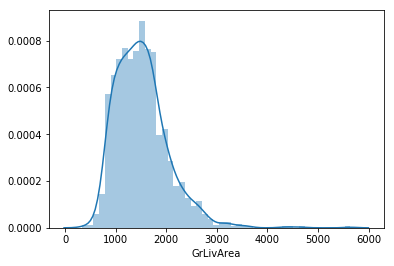

In [29]:
sns.distplot(df_train['GrLivArea']);
#skewness and kurtosis
print("Skewness: %f" % df_train['GrLivArea'].skew())
print("Kurtosis: %f" % df_train['GrLivArea'].kurt())

Skewness: 12.235742
Kurtosis: 203.584079


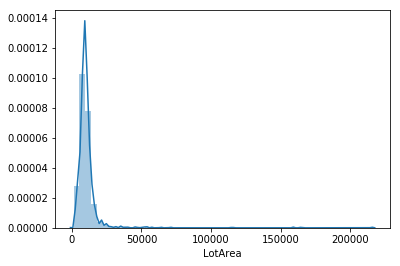

In [30]:
sns.distplot(df_train['LotArea']);
#skewness and kurtosis
print("Skewness: %f" % df_train['LotArea'].skew())
print("Kurtosis: %f" % df_train['LotArea'].kurt())

In [31]:
for df in [df_train, df_test]:
    df['GrLivArea_Log'] = np.log(df['GrLivArea'])
    df.drop('GrLivArea', inplace= True, axis = 1)
    df['LotArea_Log'] = np.log(df['LotArea'])
    df.drop('LotArea', inplace= True, axis = 1)
    
    
    
numerical_feats = df_train.dtypes[df_train.dtypes != "object"].index
   

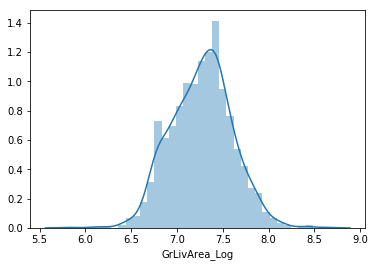

In [32]:
sns.distplot(df_train['GrLivArea_Log']);
#skewness and kurtosis

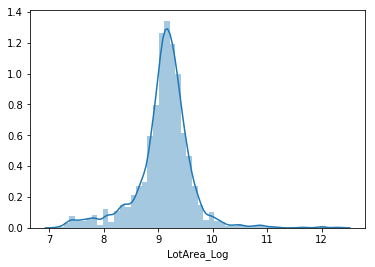

In [33]:
sns.distplot(df_train['LotArea_Log']);

## 1.2  Feature Analysis (Bi-Variate Analysis, CORR)
- Relation of features to target (SalePrice_log) ?

#### Reapply newly created log columns to the list = numerical_feats

In [34]:
numerical_feats = df_train.dtypes[df_train.dtypes != "object"].index
print("Number of Numerical features: ", len(numerical_feats))

categorical_feats = df_train.dtypes[df_train.dtypes == "object"].index
print("Number of Categorical features: ", len(categorical_feats))

Number of Numerical features:  38
Number of Categorical features:  43


### NUMERICAL VARIABLES

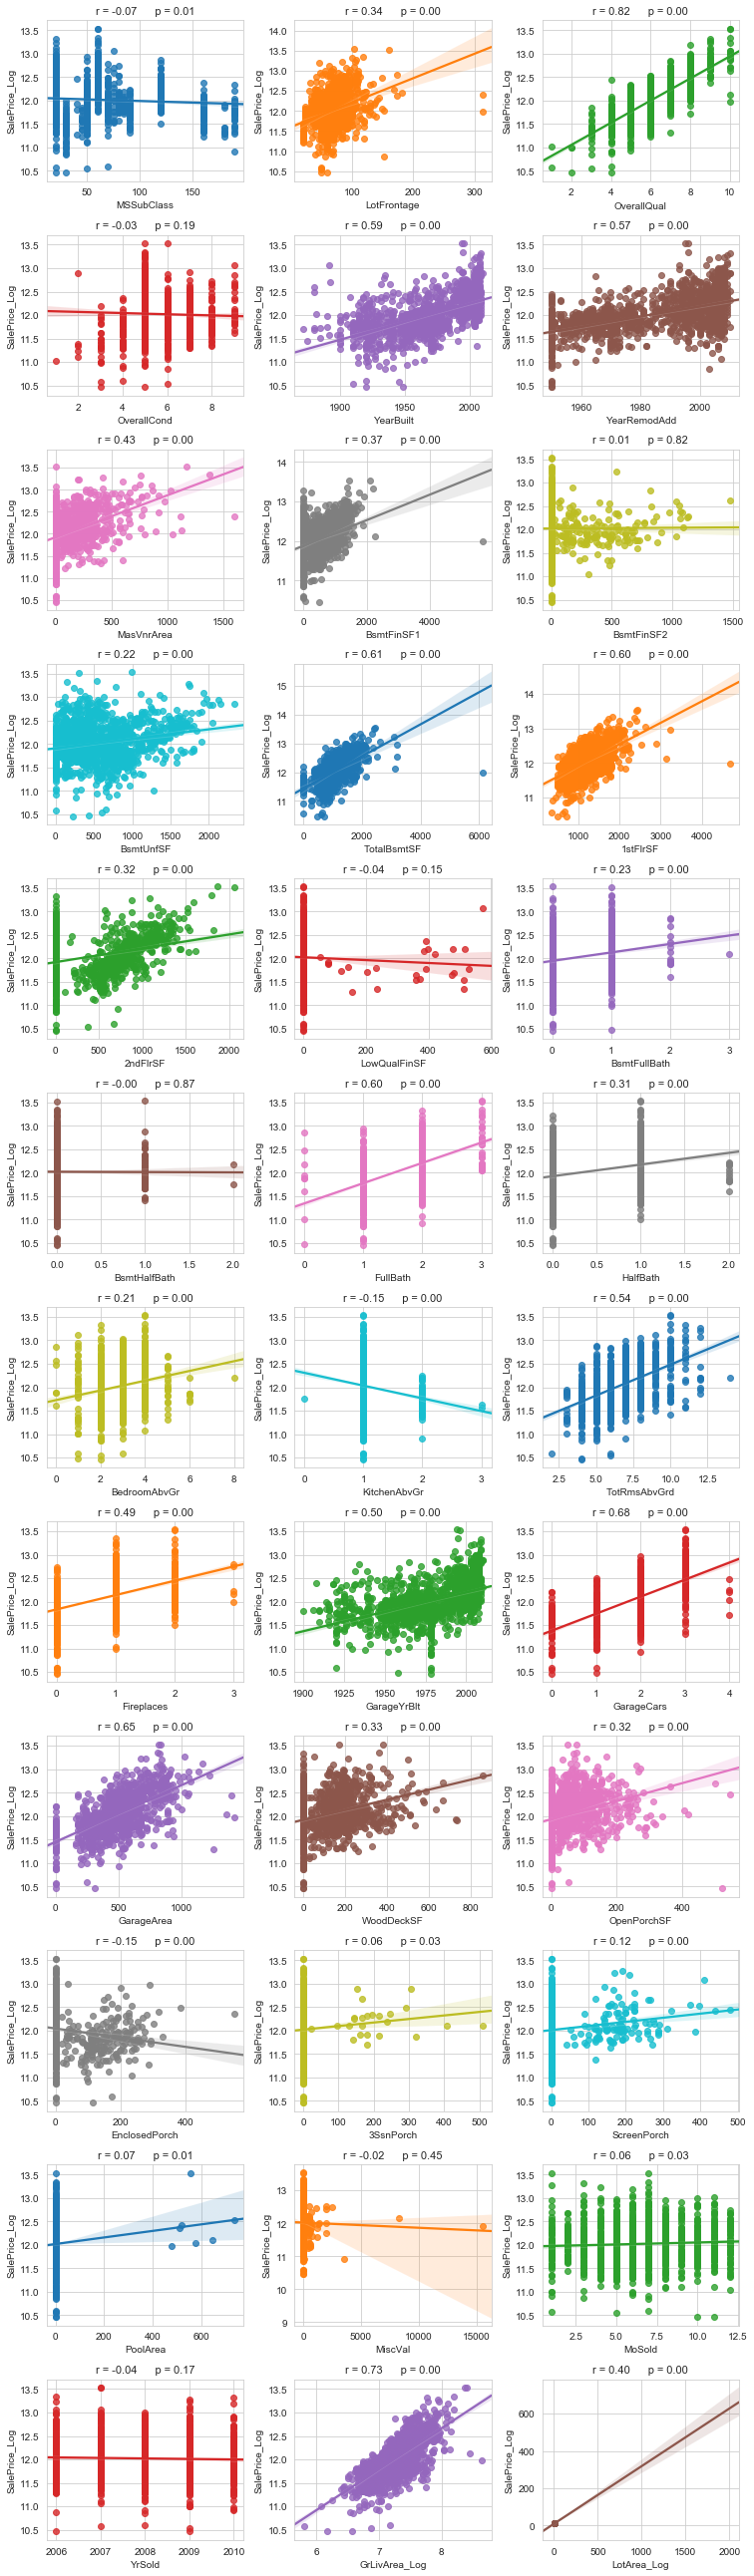

In [41]:
target = 'SalePrice_Log'

nr_rows = 12
nr_cols = 3

fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*3.5,nr_rows*3))

li_num_feats = list(numerical_feats)
li_not_plot = ['Id', 'SalePrice', 'SalePrice_Log']
li_plot_num_feats = [c for c in list(numerical_feats) if c not in li_not_plot]


for r in range(0,nr_rows):
    for c in range(0,nr_cols):  
        i = r*nr_cols+c
        if i < len(li_plot_num_feats):
            sns.regplot(df_train[li_plot_num_feats[i]], df_train[target], ax = axs[r][c])
            stp = stats.pearsonr(df_train[li_plot_num_feats[i]], df_train[target])
            #axs[r][c].text(0.4,0.9,"title",fontsize=7)
            str_title = "r = " + "{0:.2f}".format(stp[0]) + "      " "p = " + "{0:.2f}".format(stp[1])
            axs[r][c].set_title(str_title,fontsize=11)
            
plt.tight_layout()    
#plt.savefig('housing_variables.pdf')

## Conclusions Part1 - Numerical Variables

- Num Variables w/ Strong Correlation : OverallQual LotFrontage Year Built MasVnrArea BSmt'X' 1stFlrSF 2ndFlrSF FullBath TotRmsAbvGrd Garage 'X' GrLivArea_Log LotArea_Log

- Num Variables w/ Weak Correlation : MSSubClass KitchenAbvGr EnclosedPorch

- Num Variable are categorical values. 'OverallQual' 'MSSubClass'

### Outliers

In [42]:
#deleting two outlier points for GrLIvArea
df_train.sort_values(by = 'GrLivArea_Log', ascending = False)[:2]
df_train = df_train.drop(df_train[df_train['Id'] == 1299].index)
df_train = df_train.drop(df_train[df_train['Id'] == 524].index)

In [43]:
df_train = df_train.drop(
    df_train[(df_train['OverallQual']==10) & (df_train['SalePrice_Log']<12.3)].index)

In [44]:
df_train = df_train.drop(
    df_train[(df_train['GrLivArea_Log']>8.3) & (df_train['SalePrice_Log']<12.5)].index)

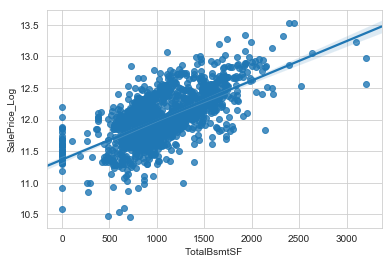

In [45]:
sns.regplot(df_train['TotalBsmtSF'],df_train['SalePrice_Log'])

In [46]:
df_train.head()
df_test.head()

Id  MSSubClass MSZoning  LotFrontage Street Alley LotShape LandContour Utilities LotConfig LandSlope Neighborhood Condition1 Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional  Fireplaces FireplaceQu GarageType  GarageYrBlt GarageFinish  GarageCars  GarageArea GarageQual GarageCond PavedDrive  WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  PoolArea PoolQC  Fence MiscFeature  MiscVal  MoSold  YrSold SaleType SaleCondition  GrLivArea_Log  LotArea_Log
0  1461          20       RH         80.0   Pave  None      Reg         Lvl    AllPub    Inside       Gtl        NAmes      Feedr       Norm     1Fam     1Story            5            6       1961          1961     Gable  CompShg     VinylSd     VinylSd       None         0.0        TA        TA     CBlock       TA       TA           No          Rec       468.0          LwQ       144.0      270.0        882.0    GasA        TA          Y      SBrkr       896         0             0           0.0           0.0         1         0             2             1          TA             5        Typ           0        None     Attchd       1961.0          Unf         1.0       730.0         TA         TA          Y         140            0              0          0          120         0   None  MnPrv        None        0       6    2010       WD        Normal       6.797940     9.360655
1  1462          20       RL         81.0   Pave  None      IR1         Lvl    AllPub    Corner       Gtl        NAmes       Norm       Norm     1Fam     1Story            6            6       1958          1958       Hip  CompShg     Wd Sdng     Wd Sdng    BrkFace       108.0        TA        TA     CBlock       TA       TA           No          ALQ       923.0          Unf         0.0      406.0       1329.0    GasA        TA          Y      SBrkr      1329         0             0           0.0           0.0         1         1             3             1          Gd             6        Typ           0        None     Attchd       1958.0          Unf         1.0       312.0         TA         TA          Y         393           36              0          0            0         0   None   None        Gar2    12500       6    2010       WD        Normal       7.192182     9.565704
2  1463          60       RL         74.0   Pave  None      IR1         Lvl    AllPub    Inside       Gtl      Gilbert       Norm       Norm     1Fam     2Story            5            5       1997          1998     Gable  CompShg     VinylSd     VinylSd       None         0.0        TA        TA      PConc       Gd       TA           No          GLQ       791.0          Unf         0.0      137.0        928.0    GasA        Gd          Y      SBrkr       928       701             0           0.0           0.0         2         1             3             1          TA             6        Typ           1          TA     Attchd       1997.0          Fin         2.0       482.0         TA         TA          Y         212           34              0          0            0         0   None  MnPrv        None        0       3    2010       WD        Normal       7.395722     9.534595
3  1464          60       RL         78.0   Pave  None      IR1         Lvl    AllPub    Inside       Gtl      Gilbert       Norm       Norm     1Fam     2Story            6            6       1998          1998     Gable  CompShg     VinylSd     VinylSd    BrkFace        20.0        TA        TA      PConc       TA       TA           No          GLQ       602.0          Unf         0.0      324.0        926.0    GasA    

In [47]:
print(df_train.shape)
print("*"*30)
print(df_test.shape)

(1449, 81)
******************************
(1459, 80)


## CORRELATION
Find columns with strong correlation to target


In [48]:
corr = df_train.corr()
corr_abs = corr.abs()

nr_num_cols = len(numerical_feats)
ser_corr = corr_abs.nlargest(nr_num_cols, target)[target]


cols_abv_corr_limit = list(ser_corr[ser_corr.values > min_val_corr].index)
cols_bel_corr_limit = list(ser_corr[ser_corr.values <= min_val_corr].index)

In [49]:
ser_corr

SalePrice_Log    1.000000
OverallQual      0.820867
GrLivArea_Log    0.737820
GarageCars       0.680204
GarageArea       0.655230
TotalBsmtSF      0.647920
1stFlrSF         0.622216
FullBath         0.596870
YearBuilt        0.586703
YearRemodAdd     0.565647
TotRmsAbvGrd     0.539556
GarageYrBlt      0.500308
Fireplaces       0.493808
MasVnrArea       0.434676
LotArea_Log      0.403531
BsmtFinSF1       0.390223
LotFrontage      0.351526
WoodDeckSF       0.335059
2ndFlrSF         0.322150
OpenPorchSF      0.321691
HalfBath         0.312449
BsmtFullBath     0.234941
BsmtUnfSF        0.222972
BedroomAbvGr     0.212020
KitchenAbvGr     0.149529
EnclosedPorch    0.149510
ScreenPorch      0.122764
PoolArea         0.074826
MSSubClass       0.072795
MoSold           0.056292
3SsnPorch        0.055567
LowQualFinSF     0.037563
YrSold           0.035591
OverallCond      0.034606
Id               0.020459
MiscVal          0.019705
BsmtFinSF2       0.006087
BsmtHalfBath     0.004132
Name: SalePr

#### List of numerical features and their correlation coefficient to target¶


In [50]:
print(ser_corr)
print("*"*30)
print("List of numerical features with r above min_val_corr :")
print(cols_abv_corr_limit)
print("*"*30)
print("List of numerical features with r below min_val_corr :")
print(cols_bel_corr_limit)

SalePrice_Log    1.000000
OverallQual      0.820867
GrLivArea_Log    0.737820
GarageCars       0.680204
GarageArea       0.655230
TotalBsmtSF      0.647920
1stFlrSF         0.622216
FullBath         0.596870
YearBuilt        0.586703
YearRemodAdd     0.565647
TotRmsAbvGrd     0.539556
GarageYrBlt      0.500308
Fireplaces       0.493808
MasVnrArea       0.434676
LotArea_Log      0.403531
BsmtFinSF1       0.390223
LotFrontage      0.351526
WoodDeckSF       0.335059
2ndFlrSF         0.322150
OpenPorchSF      0.321691
HalfBath         0.312449
BsmtFullBath     0.234941
BsmtUnfSF        0.222972
BedroomAbvGr     0.212020
KitchenAbvGr     0.149529
EnclosedPorch    0.149510
ScreenPorch      0.122764
PoolArea         0.074826
MSSubClass       0.072795
MoSold           0.056292
3SsnPorch        0.055567
LowQualFinSF     0.037563
YrSold           0.035591
OverallCond      0.034606
Id               0.020459
MiscVal          0.019705
BsmtFinSF2       0.006087
BsmtHalfBath     0.004132
Name: SalePr

### List of catgorical features and their values¶


In [51]:
for catg in list(categorical_feats) :
    print(df_train[catg].value_counts())
    print('*|*'*30)

RL         1143
RM          218
FV           62
RH           16
C (all)      10
Name: MSZoning, dtype: int64
*|**|**|**|**|**|**|**|**|**|**|**|**|**|**|**|**|**|**|**|**|**|**|**|**|**|**|**|**|**|*
Pave    1443
Grvl       6
Name: Street, dtype: int64
*|**|**|**|**|**|**|**|**|**|**|**|**|**|**|**|**|**|**|**|**|**|**|**|**|**|**|**|**|**|*
None    1359
Grvl      50
Pave      40
Name: Alley, dtype: int64
*|**|**|**|**|**|**|**|**|**|**|**|**|**|**|**|**|**|**|**|**|**|**|**|**|**|**|**|**|**|*
Reg    918
IR1    481
IR2     41
IR3      9
Name: LotShape, dtype: int64
*|**|**|**|**|**|**|**|**|**|**|**|**|**|**|**|**|**|**|**|**|**|**|**|**|**|**|**|**|**|*
Lvl    1302
Bnk      61
HLS      50
Low      36
Name: LandContour, dtype: int64
*|**|**|**|**|**|**|**|**|**|**|**|**|**|**|**|**|**|**|**|**|**|**|**|**|**|**|**|**|**|*
AllPub    1448
NoSeWa       1
Name: Utilities, dtype: int64
*|**|**|**|**|**|**|**|**|**|**|**|**|**|**|**|**|**|**|**|**|**|**|**|**|**|**|**|**|**|*
Inside     104

### CATEGORICAL VARIABLES

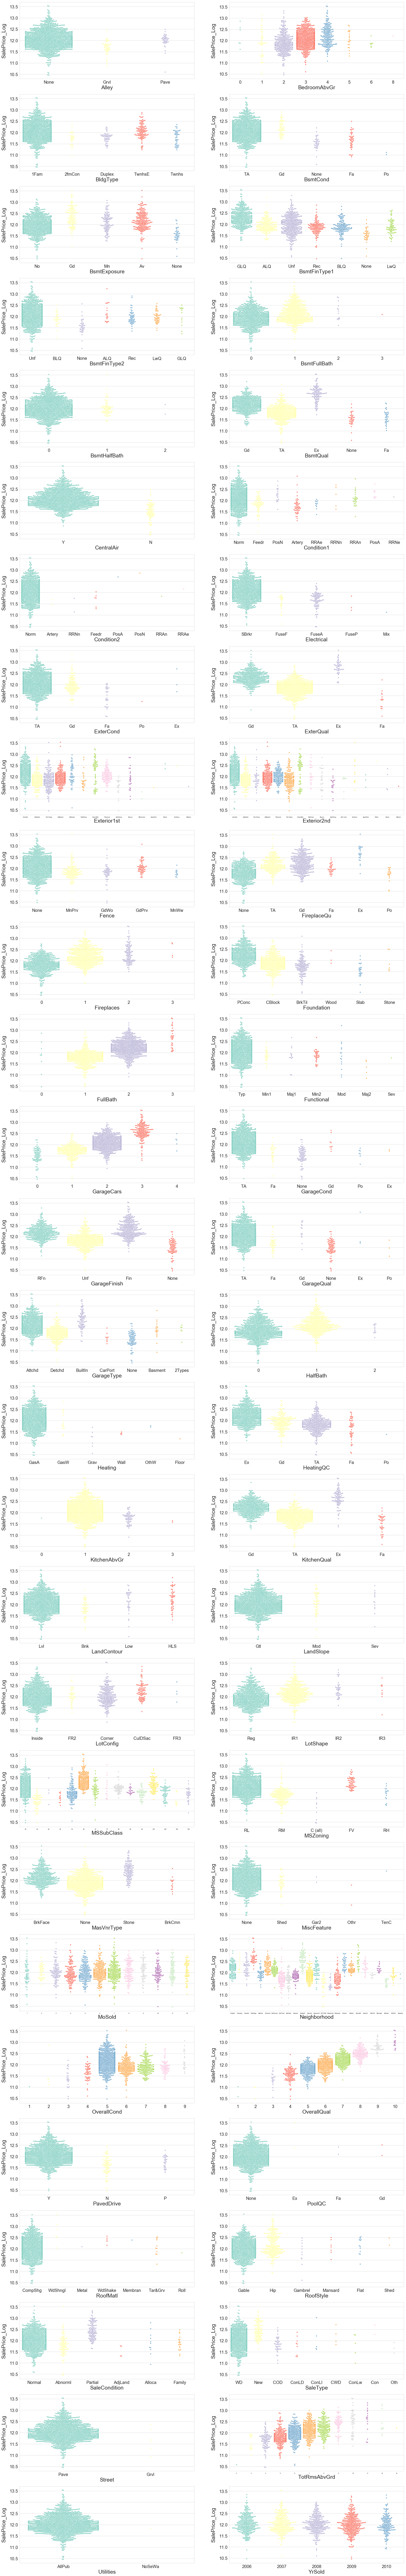

In [53]:
cat_features = ['Alley', 'BedroomAbvGr', 'BldgType', 'BsmtCond', 'BsmtExposure', 
                'BsmtFinType1', 'BsmtFinType2', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtQual', 
                'CentralAir', 'Condition1', 'Condition2', 'Electrical', 'ExterCond', 
                'ExterQual', 'Exterior1st', 'Exterior2nd', 'Fence', 'FireplaceQu', 
                'Fireplaces', 'Foundation', 'FullBath', 'Functional', 'GarageCars', 
                'GarageCond', 'GarageFinish', 'GarageQual', 'GarageType', 'HalfBath', 
                'Heating', 'HeatingQC', 'KitchenAbvGr', 'KitchenQual', 'LandContour', 
                'LandSlope', 'LotConfig', 'LotShape', 'MSSubClass', 'MSZoning', 
                'MasVnrType', 'MiscFeature', 'MoSold', 'Neighborhood', 'OverallCond', 
                'OverallQual', 'PavedDrive', 'PoolQC', 'RoofMatl', 'RoofStyle', 
                'SaleCondition', 'SaleType', 'Street', 'TotRmsAbvGrd', 'Utilities', 'YrSold']

#for sorting of charts alphabetically (list above)
fig, axs = plt.subplots(ncols=2, nrows=28, figsize=(18, 120))
plt.subplots_adjust(right=1.5, top=1.5)

for i, feature in enumerate(cat_features, 1):    
    plt.subplot(28, 2, i)
    sns.swarmplot(x=feature, y='SalePrice_Log', data=df_train, palette='Set3')
        
    plt.xlabel('{}'.format(feature), size=25)
    plt.ylabel('SalePrice_Log', size=25, labelpad=15)
    
    for j in range(2):
        if df_train[feature].value_counts().shape[0] > 10:        
            plt.tick_params(axis='x', labelsize=7)
        else:
            plt.tick_params(axis='x', labelsize=20)
        plt.tick_params(axis='y', labelsize=20)
            
plt.show()

## Conclusions Part2 - Categorical Variables

Cat Variables w/ Strong Correlation :
    OverallQual
    'MSZoning', 
    'Neighborhood', 
    'Condition2', 
    'MasVnrType', 
    'ExterQual', 
    'BsmtQual',
    'CentralAir', 
    'Electrical',
    'KitchenQual', 
    'SaleType'
    
    
    


Cat Variables w/ Weak Correlation :
    Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 
    'LotConfig', 'LandSlope', 'Condition1', 'BldgType', 'HouseStyle', 
    'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'ExterCond', 
    'Foundation', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 
    'Heating', 'HeatingQC', 'Functional', 'FireplaceQu', 'GarageType', 
    'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 
    'MiscFeature', 'SaleCondition'

In [218]:
catg_strong_corr = [ 'MSZoning', 'Neighborhood', 'Condition2', 'MasVnrType', 'ExterQual', 
                     'BsmtQual','CentralAir', 'Electrical', 'KitchenQual', 'SaleType']

catg_weak_corr = ['Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 
                  'LandSlope', 'Condition1',  'BldgType', 'HouseStyle', 'RoofStyle', 
                  'RoofMatl', 'Exterior1st', 'Exterior2nd', 'ExterCond', 'Foundation', 
                  'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 
                  'HeatingQC', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 
                  'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 
                  'SaleCondition' ]
      

In [219]:
nr_feats = len(cols_abv_corr_limit)

## Correlation matrix 1 : all numerical features
Determine features with  correlation above threshold

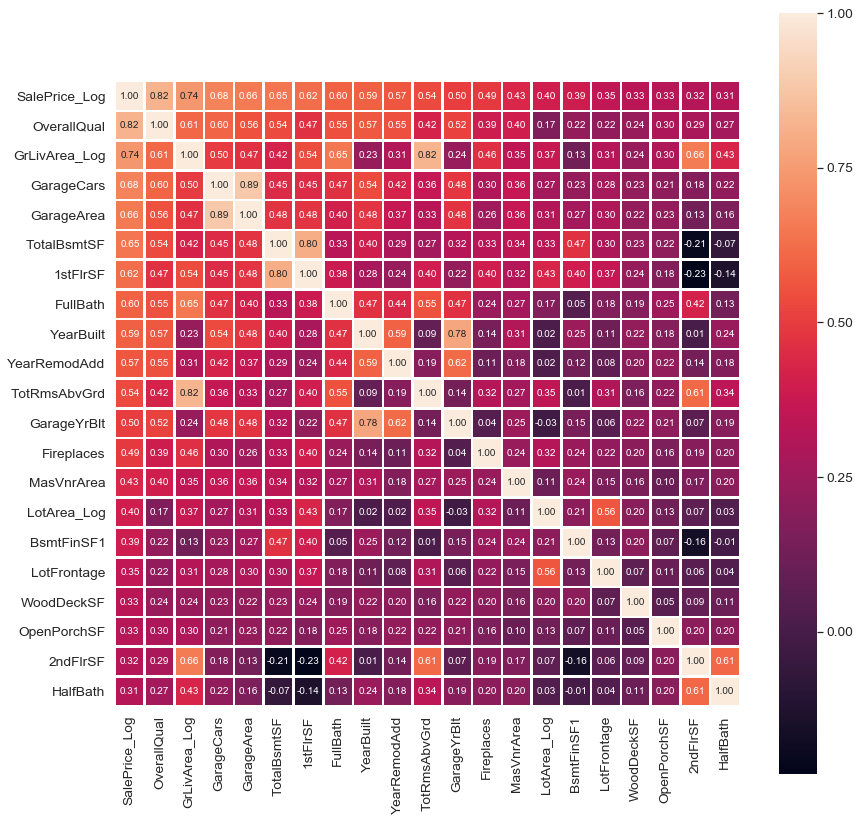

In [220]:
plot_corr_matrix(df_train, nr_feats, target)


#### To avoid failures of the ML regression models due to multicollinearity, DROP variables that corrlated??.

This is optional  - refer to main settings

# B]  Data Wrangling
*********************************
- Drop all columns with only weak correlation to SalePrice
- Handling columns with missing data
- Log values (or BoxCox)
- Drop all columns with strong correlation to similar features


### DROP Philosophy

Drop all columns with  small correlation to SalePrice

Explore : Transform Categorical to numerical 

Drop all columns with strong correlation to similar features (Numerical columns : drop similar / low correlation)

Drop multi-colonearity columns (drop with least correlation to SP)

Handling columns with missing data

Log values

### B.1.  Dropping all columns with weak correlation to SalePrice¶


In [221]:
df_train.head()
df_test.head()

Id  MSSubClass MSZoning  LotFrontage Street Alley LotShape LandContour Utilities LotConfig LandSlope Neighborhood Condition1 Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional  Fireplaces FireplaceQu GarageType  GarageYrBlt GarageFinish  GarageCars  GarageArea GarageQual GarageCond PavedDrive  WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  PoolArea PoolQC  Fence MiscFeature  MiscVal  MoSold  YrSold SaleType SaleCondition  GrLivArea_Log  LotArea_Log
0  1461          20       RH         80.0   Pave  None      Reg         Lvl    AllPub    Inside       Gtl        NAmes      Feedr       Norm     1Fam     1Story            5            6       1961          1961     Gable  CompShg     VinylSd     VinylSd       None         0.0        TA        TA     CBlock       TA       TA           No          Rec       468.0          LwQ       144.0      270.0        882.0    GasA        TA          Y      SBrkr       896         0             0           0.0           0.0         1         0             2             1          TA             5        Typ           0        None     Attchd       1961.0          Unf         1.0       730.0         TA         TA          Y         140            0              0          0          120         0   None  MnPrv        None        0       6    2010       WD        Normal       6.797940     9.360655
1  1462          20       RL         81.0   Pave  None      IR1         Lvl    AllPub    Corner       Gtl        NAmes       Norm       Norm     1Fam     1Story            6            6       1958          1958       Hip  CompShg     Wd Sdng     Wd Sdng    BrkFace       108.0        TA        TA     CBlock       TA       TA           No          ALQ       923.0          Unf         0.0      406.0       1329.0    GasA        TA          Y      SBrkr      1329         0             0           0.0           0.0         1         1             3             1          Gd             6        Typ           0        None     Attchd       1958.0          Unf         1.0       312.0         TA         TA          Y         393           36              0          0            0         0   None   None        Gar2    12500       6    2010       WD        Normal       7.192182     9.565704
2  1463          60       RL         74.0   Pave  None      IR1         Lvl    AllPub    Inside       Gtl      Gilbert       Norm       Norm     1Fam     2Story            5            5       1997          1998     Gable  CompShg     VinylSd     VinylSd       None         0.0        TA        TA      PConc       Gd       TA           No          GLQ       791.0          Unf         0.0      137.0        928.0    GasA        Gd          Y      SBrkr       928       701             0           0.0           0.0         2         1             3             1          TA             6        Typ           1          TA     Attchd       1997.0          Fin         2.0       482.0         TA         TA          Y         212           34              0          0            0         0   None  MnPrv        None        0       3    2010       WD        Normal       7.395722     9.534595
3  1464          60       RL         78.0   Pave  None      IR1         Lvl    AllPub    Inside       Gtl      Gilbert       Norm       Norm     1Fam     2Story            6            6       1998          1998     Gable  CompShg     VinylSd     VinylSd    BrkFace        20.0        TA        TA      PConc       TA       TA           No          GLQ       602.0          Unf         0.0      324.0        926.0    GasA    

In [222]:
id_test = df_test['Id']

to_drop_num  = cols_bel_corr_limit
to_drop_catg = catg_weak_corr

cols_to_drop = ['Id'] + to_drop_num + to_drop_catg 

for df in [df_train, df_test]:
    df.drop(cols_to_drop, inplace= True, axis = 1)

In [223]:
df_train.head()
df_test.head()

MSZoning  LotFrontage Neighborhood Condition2  OverallQual  YearBuilt  YearRemodAdd MasVnrType  MasVnrArea ExterQual BsmtQual  BsmtFinSF1  TotalBsmtSF CentralAir Electrical  1stFlrSF  2ndFlrSF  FullBath  HalfBath KitchenQual  TotRmsAbvGrd  Fireplaces  GarageYrBlt  GarageCars  GarageArea  WoodDeckSF  OpenPorchSF SaleType  GrLivArea_Log  LotArea_Log
0       RH         80.0        NAmes       Norm            5       1961          1961       None         0.0        TA       TA       468.0        882.0          Y      SBrkr       896         0         1         0          TA             5           0       1961.0         1.0       730.0         140            0       WD       6.797940     9.360655
1       RL         81.0        NAmes       Norm            6       1958          1958    BrkFace       108.0        TA       TA       923.0       1329.0          Y      SBrkr      1329         0         1         1          Gd             6           0       1958.0         1.0       312.0         393           36       WD       7.192182     9.565704
2       RL         74.0      Gilbert       Norm            5       1997          1998       None         0.0        TA       Gd       791.0        928.0          Y      SBrkr       928       701         2         1          TA             6           1       1997.0         2.0       482.0         212           34       WD       7.395722     9.534595
3       RL         78.0      Gilbert       Norm            6       1998          1998    BrkFace        20.0        TA       TA       602.0        926.0          Y      SBrkr       926       678         2         1          Gd             7           1       1998.0         2.0       470.0         360           36       WD       7.380256     9.208138
4       RL         43.0      StoneBr       Norm            8       1992          1992       None         0.0        Gd       Gd       263.0       1280.0          Y      SBrkr      1280         0         2         0          Gd             5           0       1992.0         2.0       506.0           0           82       WD       7.154615     8.518193

In [224]:
print(df_train.shape)
print("*"*30)
print(df_test.shape)

(1458, 31)
******************************
(1459, 30)


## Columns and Correlation after/applying dropping B.1.


In [225]:
corr1 = df_train.corr()
corr_abs_1 = corr1.abs()

nr_all_cols = len(df_train)
ser_corr_1 = corr_abs_1.nlargest(nr_all_cols, target)[target]

print(ser_corr_1)
cols_bel_corr_limit_1 = list(ser_corr_1[ser_corr_1.values <= min_val_corr].index)


for df in [df_train, df_test] :
    df.drop(cols_bel_corr_limit_1, inplace= True, axis = 1)    

SalePrice_Log    1.000000
OverallQual      0.821404
GrLivArea_Log    0.737427
GarageCars       0.681033
GarageArea       0.656128
TotalBsmtSF      0.647563
1stFlrSF         0.620500
FullBath         0.595899
YearBuilt        0.587043
YearRemodAdd     0.565992
TotRmsAbvGrd     0.537702
GarageYrBlt      0.500842
Fireplaces       0.491998
MasVnrArea       0.433353
LotArea_Log      0.402814
BsmtFinSF1       0.392283
LotFrontage      0.352432
WoodDeckSF       0.334250
OpenPorchSF      0.325215
2ndFlrSF         0.319953
HalfBath         0.314186
Name: SalePrice_Log, dtype: float64


### Validation:  New DataFrames

In [226]:
df_train.head()


MSZoning  LotFrontage Neighborhood Condition2  OverallQual  YearBuilt  YearRemodAdd MasVnrType  MasVnrArea ExterQual BsmtQual  BsmtFinSF1  TotalBsmtSF CentralAir Electrical  1stFlrSF  2ndFlrSF  FullBath  HalfBath KitchenQual  TotRmsAbvGrd  Fireplaces  GarageYrBlt  GarageCars  GarageArea  WoodDeckSF  OpenPorchSF SaleType  SalePrice_Log  GrLivArea_Log  LotArea_Log
0       RL         65.0      CollgCr       Norm            7       2003          2003    BrkFace       196.0        Gd       Gd         706          856          Y      SBrkr       856       854         2         1          Gd             8           0       2003.0           2         548           0           61       WD      12.247694       7.444249     9.041922
1       RL         80.0      Veenker       Norm            6       1976          1976       None         0.0        TA       Gd         978         1262          Y      SBrkr      1262         0         2         0          TA             6           1       1976.0           2         460         298            0       WD      12.109011       7.140453     9.169518
2       RL         68.0      CollgCr       Norm            7       2001          2002    BrkFace       162.0        Gd       Gd         486          920          Y      SBrkr       920       866         2         1          Gd             6           1       2001.0           2         608           0           42       WD      12.317167       7.487734     9.328123
3       RL         60.0      Crawfor       Norm            7       1915          1970       None         0.0        TA       TA         216          756          Y      SBrkr       961       756         1         0          Gd             7           1       1998.0           3         642           0           35       WD      11.849398       7.448334     9.164296
4       RL         84.0      NoRidge       Norm            8       2000          2000    BrkFace       350.0        Gd       Gd         655         1145          Y      SBrkr      1145      1053         2         1          Gd             9           1       2000.0           3         836         192           84       WD      12.429216       7.695303     9.565214

In [227]:
df_test.head()


MSZoning  LotFrontage Neighborhood Condition2  OverallQual  YearBuilt  YearRemodAdd MasVnrType  MasVnrArea ExterQual BsmtQual  BsmtFinSF1  TotalBsmtSF CentralAir Electrical  1stFlrSF  2ndFlrSF  FullBath  HalfBath KitchenQual  TotRmsAbvGrd  Fireplaces  GarageYrBlt  GarageCars  GarageArea  WoodDeckSF  OpenPorchSF SaleType  GrLivArea_Log  LotArea_Log
0       RH         80.0        NAmes       Norm            5       1961          1961       None         0.0        TA       TA       468.0        882.0          Y      SBrkr       896         0         1         0          TA             5           0       1961.0         1.0       730.0         140            0       WD       6.797940     9.360655
1       RL         81.0        NAmes       Norm            6       1958          1958    BrkFace       108.0        TA       TA       923.0       1329.0          Y      SBrkr      1329         0         1         1          Gd             6           0       1958.0         1.0       312.0         393           36       WD       7.192182     9.565704
2       RL         74.0      Gilbert       Norm            5       1997          1998       None         0.0        TA       Gd       791.0        928.0          Y      SBrkr       928       701         2         1          TA             6           1       1997.0         2.0       482.0         212           34       WD       7.395722     9.534595
3       RL         78.0      Gilbert       Norm            6       1998          1998    BrkFace        20.0        TA       TA       602.0        926.0          Y      SBrkr       926       678         2         1          Gd             7           1       1998.0         2.0       470.0         360           36       WD       7.380256     9.208138
4       RL         43.0      StoneBr       Norm            8       1992          1992       None         0.0        Gd       Gd       263.0       1280.0          Y      SBrkr      1280         0         2         0          Gd             5           0       1992.0         2.0       506.0           0           82       WD       7.154615     8.518193

## List of all features with strong correlation to SalePrice_Log
after dropping all coumns with weak correlation

In [228]:
corr = df_train.corr()
corr_abs = corr.abs()

nr_all_cols = len(df_train)
print (corr_abs.nlargest(nr_all_cols, target)[target])

SalePrice_Log    1.000000
OverallQual      0.821404
GrLivArea_Log    0.737427
GarageCars       0.681033
GarageArea       0.656128
TotalBsmtSF      0.647563
1stFlrSF         0.620500
FullBath         0.595899
YearBuilt        0.587043
YearRemodAdd     0.565992
TotRmsAbvGrd     0.537702
GarageYrBlt      0.500842
Fireplaces       0.491998
MasVnrArea       0.433353
LotArea_Log      0.402814
BsmtFinSF1       0.392283
LotFrontage      0.352432
WoodDeckSF       0.334250
OpenPorchSF      0.325215
2ndFlrSF         0.319953
HalfBath         0.314186
Name: SalePrice_Log, dtype: float64


## Correlation Matrix 2 :
    All features with strong correlation to SalePrice¶


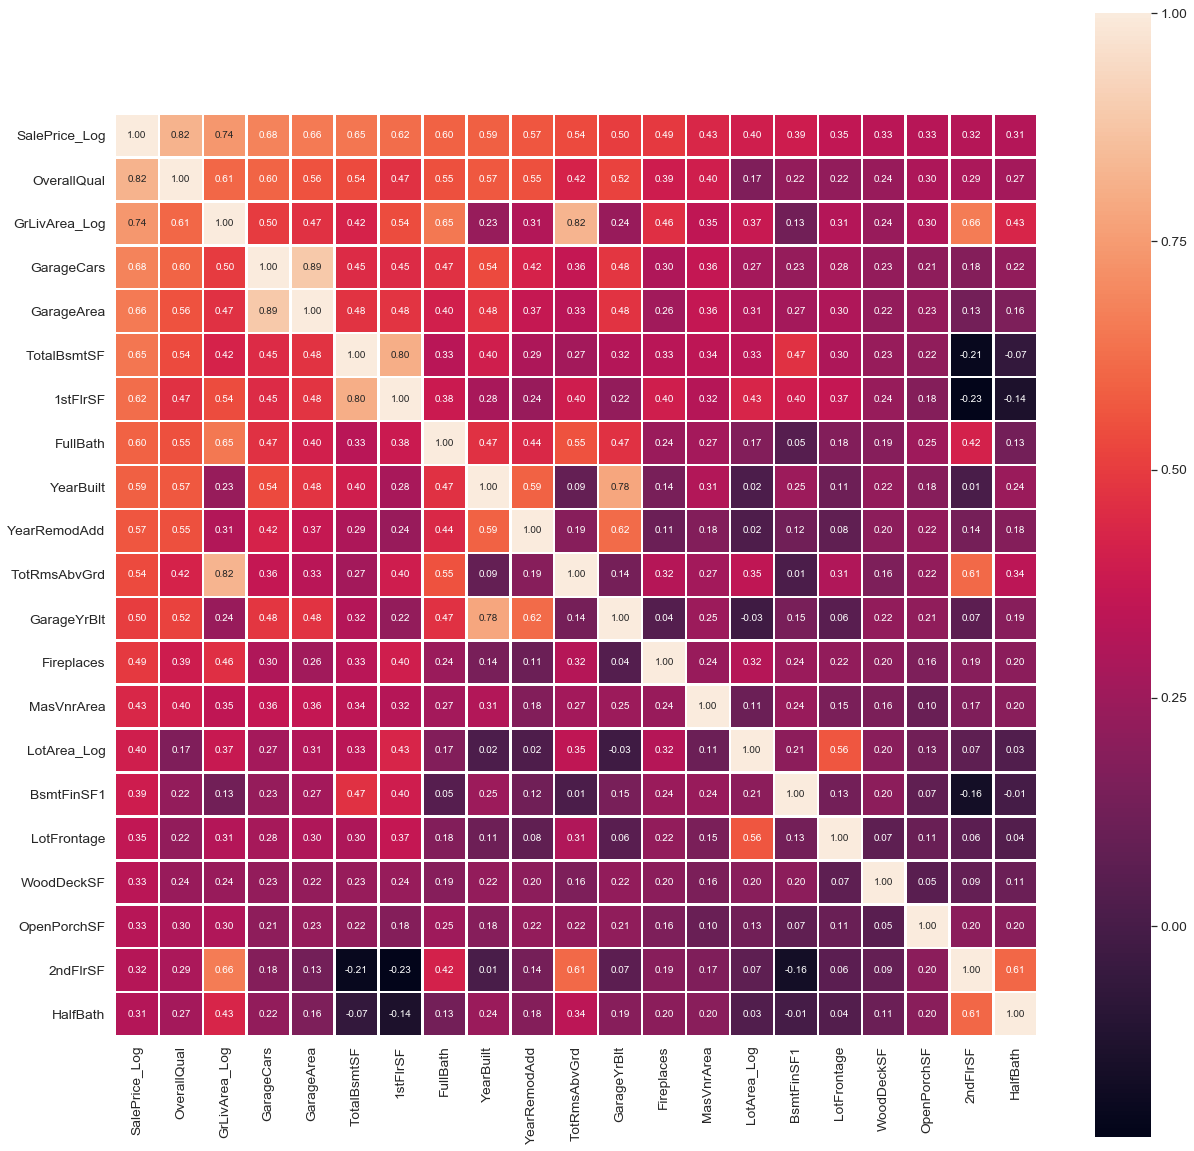

In [229]:
nr_feats=len(df_train.columns)
plot_corr_matrix(df_train, nr_feats, target)

#### Check for Multicollinearity

Strong correlation of these features to other, similar features:

'GrLivArea_Log' and 'TotRmsAbvGrd'

'GarageCars' and 'GarageArea'

'TotalBsmtSF' and '1stFlrSF'

'YearBuilt' and 'GarageYrBlt'

In [230]:
drop_similar = 1

cols = corr_abs.nlargest(nr_all_cols, target)[target].index
cols = list(cols)

if drop_similar == 1 :
    for col in ['GarageArea','1stFlrSF','TotRmsAbvGrd','GarageYrBlt'] :
        if col in cols: 
            cols.remove(col)

In [231]:
cols = list(cols)
print(cols)
print('|' * 300)
feats = cols.copy()
feats.remove('SalePrice_Log')
print(feats)

['SalePrice_Log', 'OverallQual', 'GrLivArea_Log', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt', 'YearRemodAdd', 'Fireplaces', 'MasVnrArea', 'LotArea_Log', 'BsmtFinSF1', 'LotFrontage', 'WoodDeckSF', 'OpenPorchSF', '2ndFlrSF', 'HalfBath']
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
['OverallQual', 'GrLivArea_Log', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt', 'YearRemodAdd', 'Fireplaces', 'MasVnrArea', 'LotArea_Log', 'BsmtFinSF1', 'LotFrontage', 'WoodDeckSF', 'OpenPorchSF', '2ndFlrSF', 'HalfBath']


## Model Fitting - Ali or VAl

In [232]:
df_train_ml = df_train[feats].copy()
df_test_ml  = df_test[feats].copy()

y = df_train[target]

In [233]:
print(df_train_ml.shape)
print(df_test_ml.shape)


(1458, 16)
(1459, 16)


In [234]:
df_train_ml.head()
df_test_ml.head()

OverallQual  GrLivArea_Log  GarageCars  TotalBsmtSF  FullBath  YearBuilt  YearRemodAdd  Fireplaces  MasVnrArea  LotArea_Log  BsmtFinSF1  LotFrontage  WoodDeckSF  OpenPorchSF  2ndFlrSF  HalfBath
0            5       6.797940         1.0        882.0         1       1961          1961           0         0.0     9.360655       468.0         80.0         140            0         0         0
1            6       7.192182         1.0       1329.0         1       1958          1958           0       108.0     9.565704       923.0         81.0         393           36         0         1
2            5       7.395722         2.0        928.0         2       1997          1998           1         0.0     9.534595       791.0         74.0         212           34       701         1
3            6       7.380256         2.0        926.0         2       1998          1998           1        20.0     9.208138       602.0         78.0         360           36       678         1
4            8       7.154615         2.0       1280.0         2       1992          1992           0         0.0     8.518193       263.0         43.0           0           82         0         0

dummify_cols = ['OverallQual']

train_dummy = pd.get_dummies(df_train_ml.loc[:, dummify_cols], drop_first=True)
test_dummy = pd.get_dummies(df_test_ml.loc[:, dummify_cols], drop_first=True)

df_train_ml.drop(dummify_cols, axis=1, inplace=True)
df_train_ml = pd.concat([df_train_ml, train_dummy], axis=1)
df_test_ml.drop(dummify_cols, axis=1, inplace=True)
df_test_ml = pd.concat([df_test_ml, test_dummy], axis=1)

submission = pd.DataFrame()
submission['Id'] = df_test_ml

Y=df_train_ml['SalePrice']
X=df_train_ml.loc[:, ~df_train_ml.columns.isin(['Id','SalePrice'])]
test2=df_test_ml.loc[:, ~df_test_ml.columns.isin(['Id'])]

lm = LinearRegression(normalize=False)
lm.fit(X, Y)
predictions = lm.predict(test2)

# COMBINE data

In [235]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
df_train_ml_sc = sc.fit_transform(df_train_ml)
df_test_ml_sc = sc.transform(df_test_ml)

In [236]:
df_train_ml_sc = pd.DataFrame(df_train_ml_sc)
df_train_ml_sc.head()

0         1         2         3         4         5         6         7         8         9         10        11        12        13        14        15
0  0.658506  0.539624  0.313159 -0.473766  0.793546  1.052959  0.880362 -0.952231  0.521228 -0.129585  0.617283 -0.230217 -0.750831  0.225982  1.167626  1.229699
1 -0.068293 -0.380198  0.313159  0.504925  0.793546  0.158428 -0.428115  0.605965 -0.574433  0.118848  1.245719  0.482939  1.627328 -0.708304 -0.794354 -0.760202
2  0.658506  0.671287  0.313159 -0.319490  0.793546  0.986698  0.831900  0.605965  0.331164  0.427653  0.108989 -0.087585 -0.750831 -0.065025  1.195195  1.229699
3  0.658506  0.551993  1.652119 -0.714823 -1.025620 -1.862551 -0.718888  0.605965 -0.574433  0.108680 -0.514826 -0.467935 -0.750831 -0.172238  0.942481 -0.760202
4  1.385305  1.299759  1.652119  0.222888  0.793546  0.953567  0.734975  0.605965  1.382104  0.889271  0.499451  0.673114  0.781406  0.578253  1.624809  1.229699

In [237]:
X = df_train_ml.copy()
y = df_train[target]
X_test = df_test_ml.copy()

X_sc = df_train_ml_sc.copy()
y_sc = df_train[target]
X_test_sc = df_test_ml_sc.copy()

X.info()
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1458 entries, 0 to 1459
Data columns (total 16 columns):
OverallQual      1458 non-null int64
GrLivArea_Log    1458 non-null float64
GarageCars       1458 non-null int64
TotalBsmtSF      1458 non-null int64
FullBath         1458 non-null int64
YearBuilt        1458 non-null int64
YearRemodAdd     1458 non-null int64
Fireplaces       1458 non-null int64
MasVnrArea       1458 non-null float64
LotArea_Log      1458 non-null float64
BsmtFinSF1       1458 non-null int64
LotFrontage      1458 non-null float64
WoodDeckSF       1458 non-null int64
OpenPorchSF      1458 non-null int64
2ndFlrSF         1458 non-null int64
HalfBath         1458 non-null int64
dtypes: float64(4), int64(12)
memory usage: 193.6 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 16 columns):
OverallQual      1459 non-null int64
GrLivArea_Log    1459 non-null float64
GarageCars       1459 non-null float64
TotalBsmtSF      1

In [238]:
X.head()
X_sc.head()



0         1         2         3         4         5         6         7         8         9         10        11        12        13        14        15
0  0.658506  0.539624  0.313159 -0.473766  0.793546  1.052959  0.880362 -0.952231  0.521228 -0.129585  0.617283 -0.230217 -0.750831  0.225982  1.167626  1.229699
1 -0.068293 -0.380198  0.313159  0.504925  0.793546  0.158428 -0.428115  0.605965 -0.574433  0.118848  1.245719  0.482939  1.627328 -0.708304 -0.794354 -0.760202
2  0.658506  0.671287  0.313159 -0.319490  0.793546  0.986698  0.831900  0.605965  0.331164  0.427653  0.108989 -0.087585 -0.750831 -0.065025  1.195195  1.229699
3  0.658506  0.551993  1.652119 -0.714823 -1.025620 -1.862551 -0.718888  0.605965 -0.574433  0.108680 -0.514826 -0.467935 -0.750831 -0.172238  0.942481 -0.760202
4  1.385305  1.299759  1.652119  0.222888  0.793546  0.953567  0.734975  0.605965  1.382104  0.889271  0.499451  0.673114  0.781406  0.578253  1.624809  1.229699

# BASIC REGRESSION MODELS

## LINEAR

In [239]:
from sklearn.model_selection import GridSearchCV
score_calc = 'neg_mean_squared_error'

In [240]:
def get_best_score(grid):
    
    best_score = np.sqrt(-grid.best_score_)
    print(best_score)    
    print(grid.best_params_)
    print(grid.best_estimator_)
    
    return best_score

In [244]:
sub_linreg = pd.DataFrame()
sub_linreg['Id'] = id_test
sub_linreg['SalePrice'] = pred_linreg_all

if use_logvals == 1:
    sub_linreg['SalePrice'] = np.exp(sub_linreg['SalePrice']) 
sub_linreg.to_csv('linreg.csv',index=False)
sub_linreg.head()

Id      SalePrice
0  1461  113932.273333
1  1462  161206.655388
2  1463  191512.650168
3  1464  200530.614688
4  1465  181299.919472

## RIDGE

In [248]:
from sklearn.linear_model import Ridge

ridge = Ridge()
parameters = {'alpha':[0.001,0.005,0.01,0.1,0.5,1], 'normalize':[True,False], 'tol':[1e-06,5e-06,1e-05,5e-05]}
grid_ridge = GridSearchCV(ridge, parameters, cv=nr_cv, verbose=1, scoring = score_calc)
grid_ridge.fit(X, y)

sc_ridge = get_best_score(grid_ridge)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.13558126872415935
{'alpha': 0.01, 'normalize': True, 'tol': 1e-06}
Ridge(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=True, random_state=None, solver='auto', tol=1e-06)


[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:    1.7s finished


In [251]:
pred_ridge_all = grid_ridge.predict(X_test)

sub_ridge = pd.DataFrame()
sub_ridge['Id'] = id_test
sub_ridge['SalePrice'] = pred_ridge_all

if use_logvals == 1:
    sub_ridge['SalePrice'] = np.exp(sub_ridge['SalePrice']) 
    
sub_ridge.to_csv('ridge.csv',index=False)
sub_ridge.head()


Id      SalePrice
0  1461  114002.473391
1  1462  161142.357842
2  1463  191911.835685
3  1464  200910.718192
4  1465  180992.507125